In [18]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
from decouple import config
import locale

# Establecemos el locale para usar el formato español (o de otros países que usan punto para miles y coma para decimales)
locale.setlocale(locale.LC_ALL, 'es_ES.UTF-8')

engine = sql.create_engine('mssql+pyodbc://IPSDB-Replica/Liquidacion?driver=ODBC+Driver+17+for+SQL+Server')
engine_plus = sql.create_engine('mssql+pyodbc://IPSBD\\Plus/Liquidacion?driver=ODBC+Driver+17+for+SQL+Server')
engine_Refuerzo = sql.create_engine('mssql+pyodbc://IPSBD\\PlusExtra/Liquidacion?driver=ODBC+Driver+17+for+SQL+Server')

liquidacion = config("LIQUIDACION")

In [19]:
cons_creditos = f"""SELECT L.PLLA, L.ORDEN, L.AFILIADO, SUM(MONTO) AS CREDITOS
FROM [{liquidacion}].dbo.Liquidacion L
INNER JOIN Codigos C ON C.CODIGO=L.CODIGO
WHERE C.TIPO='C'
--AND L.CODIGO NOT IN ('05','07','0Y')
GROUP BY L.PLLA, L.ORDEN, L.AFILIADO""".format(liquidacion)

creditos = pd.read_sql(cons_creditos, engine)
cons_beneficios = f"""SELECT D.CONTROL, D.PLLA, D.ORDEN, D.AFILIADO, D.SEXO, DL.BENEFICIO, B.DETALLE AS BENEFICIO_TIPO, B.TIPO,
R.DETALLE AS REPARTICION, R.TIPOREPARTICION FROM DATOSAFILIADO D INNER JOIN BENEFICIO B ON B.COD=COD_BENEFICIO
INNER JOIN REPARTICION R ON R.COD=LETRA
INNER JOIN [{liquidacion}].dbo.DatosAfiliado DL on DL.CONTROL=D.CONTROL""".format(liquidacion=liquidacion)

beneficios = pd.read_sql(cons_beneficios, engine)
brutos = beneficios.merge(creditos, on=['PLLA', 'ORDEN', 'AFILIADO'], how='left').fillna(0.0)

brutos["BRUTO"] = brutos["BENEFICIO"] + brutos["CREDITOS"]

In [20]:

cons_creditos_plus = f"""SELECT L.PLLA, L.ORDEN, L.AFILIADO, SUM(MONTO) AS CREDITOS
FROM [{liquidacion}].dbo.Liquidacion L
INNER JOIN Codigos C ON C.CODIGO=L.CODIGO
WHERE C.TIPO='C'
GROUP BY L.PLLA, L.ORDEN, L.AFILIADO""".format(liquidacion)

creditos_plus = pd.read_sql(cons_creditos_plus, engine_plus)
cons_beneficios_plus = f"""SELECT D.CONTROL, D.PLLA, D.ORDEN, D.AFILIADO, D.SEXO, DL.BENEFICIO, B.DETALLE AS BENEFICIO_TIPO, B.TIPO, 
R.DETALLE AS REPARTICION FROM DATOSAFILIADO D INNER JOIN BENEFICIO B ON B.COD=COD_BENEFICIO
INNER JOIN REPARTICION R ON R.COD=LETRA
INNER JOIN [{liquidacion}].dbo.DatosAfiliado DL on DL.CONTROL=D.CONTROL""".format(liquidacion=liquidacion)

beneficios_plus = pd.read_sql(cons_beneficios_plus, engine_plus)
brutos_plus = beneficios_plus.merge(creditos_plus, on=['PLLA', 'ORDEN', 'AFILIADO'], how='left').fillna(0.0)

brutos_plus["BRUTO"] = brutos_plus["BENEFICIO"] + brutos_plus["CREDITOS"]

In [21]:

cons_creditos_Refuerzo = f"""SELECT L.PLLA, L.ORDEN, L.AFILIADO, SUM(MONTO) AS CREDITOS
FROM [{liquidacion}].dbo.Liquidacion L
INNER JOIN Codigos C ON C.CODIGO=L.CODIGO
WHERE C.TIPO='C'
GROUP BY L.PLLA, L.ORDEN, L.AFILIADO""".format(liquidacion)

creditos_Refuerzo = pd.read_sql(cons_creditos_Refuerzo, engine_Refuerzo)
cons_beneficios_Refuerzo = f"""SELECT D.CONTROL, D.PLLA, D.ORDEN, D.AFILIADO, D.SEXO, DL.BENEFICIO, B.DETALLE AS BENEFICIO_TIPO, B.TIPO,
R.DETALLE AS REPARTICION FROM DATOSAFILIADO D INNER JOIN BENEFICIO B ON B.COD=COD_BENEFICIO
INNER JOIN REPARTICION R ON R.COD=LETRA
INNER JOIN [{liquidacion}].dbo.DatosAfiliado DL on DL.CONTROL=D.CONTROL""".format(liquidacion=liquidacion)

beneficios_Refuerzo = pd.read_sql(cons_beneficios_Refuerzo, engine_Refuerzo)
brutos_Refuerzo = beneficios_plus.merge(creditos_Refuerzo, on=['PLLA', 'ORDEN', 'AFILIADO'], how='left').fillna(0.0)

brutos_Refuerzo["BRUTO"] = brutos_Refuerzo["BENEFICIO"] + brutos_Refuerzo["CREDITOS"]

brutos["TIPOREPARTICION"] = brutos["TIPOREPARTICION"].replace({"NO": "Descentralizados", 
    "SP": "Salud Pública", "AC": "Adm. Central", "MOVILIDADES": "Mov. Varias Reparticiones",
    "Legisladores": "Legislativo", "DOC": "Docentes", "JUPOLICIA": "Policia", "MG": "Adm. Central"})

In [22]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

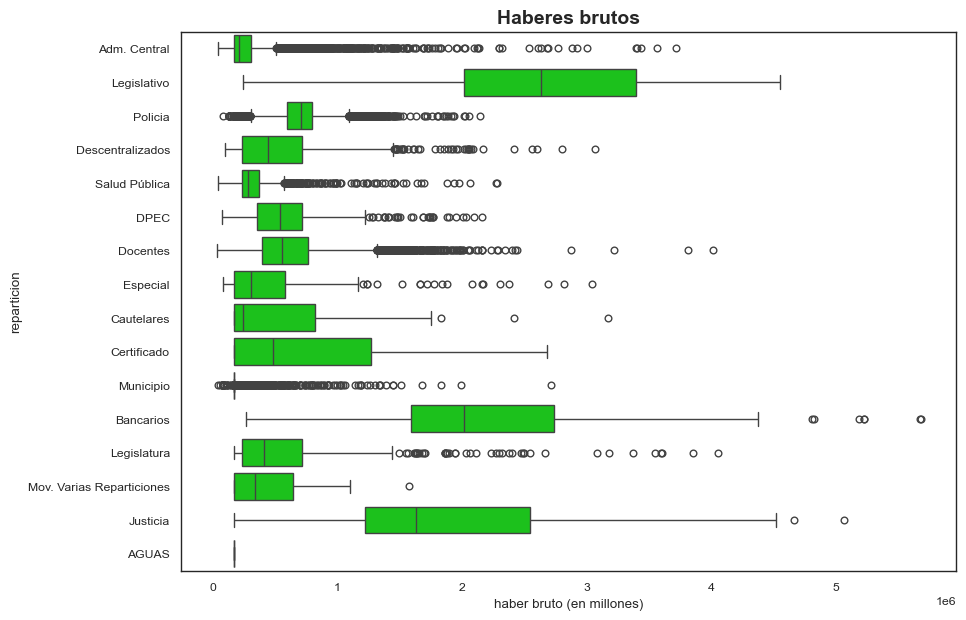

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 7))

sns.color_palette("Spectral")

''' hacer una grafica con seaborn tipo boxplot del bruto por reparticion
ordenado de mayor a menor por mayores brutos y solo de las primeras 10 reparticiones
de mayor BRUTO, con las reparticiones en columnas de manera vertical '''

top_10_reparticiones = brutos.groupby("TIPOREPARTICION")["BRUTO"].sum().nlargest(10).index

sns.boxplot(x="BRUTO", y="TIPOREPARTICION", data=brutos, color="#00DD00")

plt.title("Haberes brutos", 
          fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})
plt.ylabel('reparticion')
plt.xlabel('haber bruto (en millones)')
plt.show()



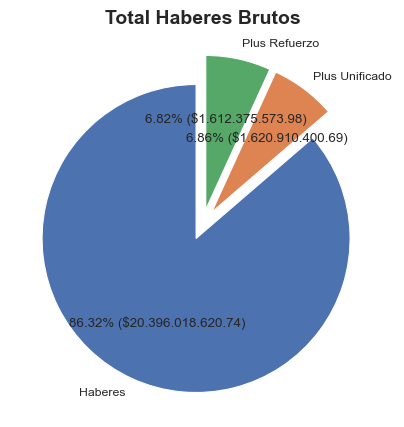

In [24]:
costos = [ brutos["BRUTO"].sum(), brutos_plus["BRUTO"].sum(), brutos_Refuerzo["BRUTO"].sum()]

sns.set_theme("paper")
sns.set_style("white")
fig = plt.figure(figsize=(5,5))
plt.pie(costos, autopct=lambda p:f'{p:.2f}% (${p*sum(costos)/100 :,.2f})'.replace(',','.'), 
        shadow=False, startangle=90, labels=["Haberes", "Plus Unificado", "Plus Refuerzo"], explode=[0.1, 0.1,0.1])

plt.title("Total Haberes Brutos", fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})

plt.show()



Text(0.5, 1.0, 'Total Haberes Brutos por Tipo Repartición')

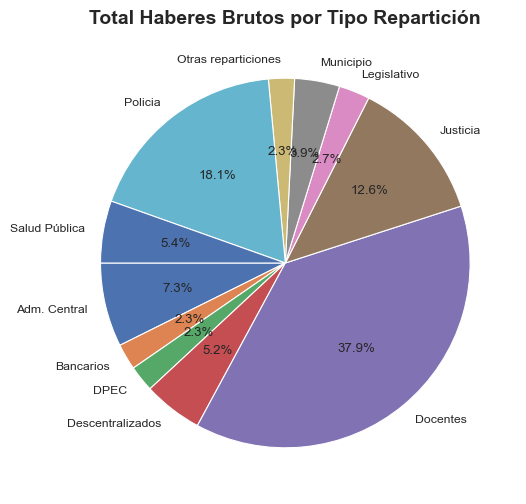

In [25]:


# Obtener las 10 primeras reparticiones con mayor BRUTO
top_10_reparticiones = brutos.groupby("TIPOREPARTICION")["BRUTO"].sum().nlargest(10).index

# Calcular el total del BRUTO del resto de las reparticiones
total_resto_reparticiones = brutos[~brutos['TIPOREPARTICION'].isin(top_10_reparticiones)]['BRUTO'].sum()

# Crear los datos para el gráfico de pastel
data_top_15 = brutos.loc[brutos['TIPOREPARTICION'].isin(top_10_reparticiones), ["TIPOREPARTICION", "BRUTO"]]

# Concatenar las series
data_top_15.loc[len(data_top_15)] = ["Otras reparticiones", total_resto_reparticiones]

data_top_15.groupby("TIPOREPARTICION").sum("BRUTO").plot.pie(y="BRUTO", figsize=(6,6), autopct="%1.1f%%", label="", 
                                                        pctdistance=0.6, startangle=180)
plt.legend().set_visible(False)
plt.title("Total Haberes Brutos por Tipo Repartición", fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})




NameError: name 'data_top_15_grp' is not defined

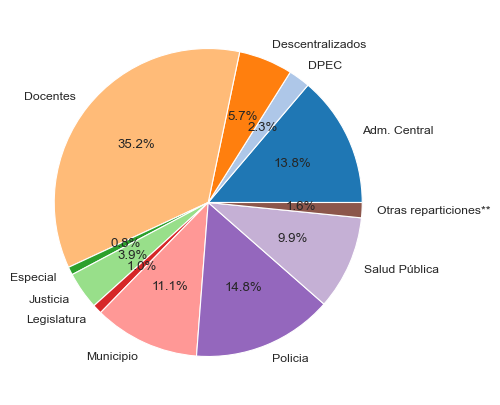

In [26]:
from palettable.tableau import Tableau_20

import matplotlib.cbook as cbook

colores = Tableau_20.hex_colors

# Obtener las 10 primeras reparticiones con mayor BRUTO
top_10_reparticiones_cantidad = brutos.groupby("TIPOREPARTICION").count().nlargest(10, "CONTROL").index

# Calcular el total del BRUTO del resto de las reparticiones
resto_reparticiones = brutos[~brutos['TIPOREPARTICION'].isin(top_10_reparticiones_cantidad)]

total_resto_reparticiones = resto_reparticiones.count()["CONTROL"].sum()

# Crear los datos para el gráfico de pastel
data_top_10 = brutos.loc[brutos['TIPOREPARTICION'].isin(top_10_reparticiones_cantidad), ["TIPOREPARTICION", "CONTROL"]]


data_top_10_grp = data_top_10.groupby("TIPOREPARTICION").count()["CONTROL"]

# Concatenar las series
data_top_10_grp = pd.concat( [data_top_10_grp, pd.Series({"Otras reparticiones**": total_resto_reparticiones})] )

axes = data_top_10_grp.plot.pie(y="BRUTO", figsize=(5,5), autopct="%1.1f%%", label="", 
    colors=colores[:len(data_top_15)])
    
plt.text(-1.30, -1.30, '*sobre un total de {} beneficios'.format(data_top_15_grp.sum()), fontsize=6, fontweight='normal', color='gray')
plt.text(-1.30, -1.37, '**' + ",".join(resto_reparticiones["REPARTICION"].unique()), fontsize=6, fontweight='normal', color='gray', wrap=True, verticalalignment='top')


plt.legend().set_visible(False)
plt.title("Beneficios por tipo de repartición", fontdict={'family': 'Arial', 'size': 12,
    'weight': 'bold', 'style': 'normal'})
plt.rcParams['savefig.dpi'] = 600 
plt.show()

Text(0.5, 1.0, 'Beneficios por Tipo')

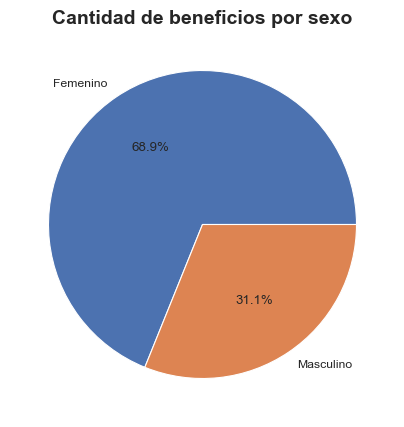

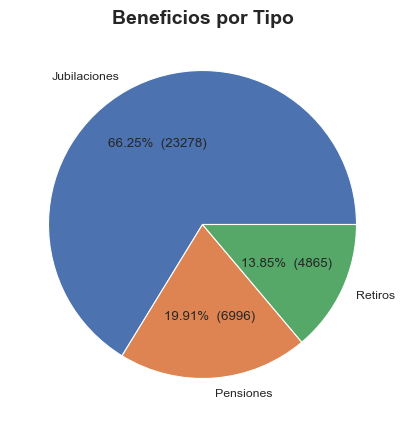

In [ ]:
brutos["SEXO"] = brutos.apply(lambda x: "Masculino" if x["SEXO"] == "M" else "Femenino", axis=1)
brutos.groupby("SEXO")["SEXO"].count().plot.pie(y="BRUTO", figsize=(5,5), autopct="%1.1f%%", label='')
plt.title("Cantidad de beneficios por sexo", fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})

brutos["JPR"] = brutos.apply(lambda x: "Retiros" if x["REPARTICION"] in ("Retiro Policial", "Retiro Carcelario") else "Pensiones" if x["TIPO"]=='pen' else 'Jubilaciones', axis=1)
brutos.groupby("JPR").count().plot.pie(y="BRUTO", figsize=(5,5), autopct=make_autopct(brutos["JPR"].value_counts()), label='')
plt.legend().remove()
plt.title('Beneficios por Tipo',  fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})
